In [ ]:
!pip install xgboost

In [13]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Attempt #1 - no additional feature engineering

In [15]:
df = pd.read_csv('Davis.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
#drop the columns that are not needed, unnamed:0 and hospital
df = df.drop(['Unnamed: 0', 'hospital'], axis=1)

In [16]:
df.dtypes

year             int64
monthday         int64
month            int64
day              int64
attendences    float64
min            float64
max            float64
aver           float64
Hosp_ID          int64
Time_ID          int64
DAT            float64
ThreeDAT       float64
EHIaccl        float64
dow              int64
Sun              int64
Mon              int64
Tue              int64
Wed              int64
Thu              int64
Fri              int64
Sat              int64
Jan              int64
Feb              int64
Mar              int64
Apr              int64
May              int64
Jun              int64
Jul              int64
Aug              int64
Sep              int64
Oct              int64
Nov              int64
Dec              int64
Year_1           int64
Year_2           int64
Year_3           int64
Year_4           int64
Year_5           int64
Year_6           int64
Year_7           int64
Year_8           int64
dtype: object

In [17]:
#separate out the features and target variable
X, y = df.drop('attendences', axis=1), df[['attendences']]

In [18]:
#Split data into train/test split
X_train, X_test, y_train, y_test = X[:'2014'], X['2015':], y[:'2014'], y['2015':]

In [19]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [23]:
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "hist"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

In [24]:
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_reg)

In [25]:
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 21.290


c:\Users\kentm\Documents\Jupyter Notebooks\ed visit timeseries\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

In [27]:
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
)

[0]	train-rmse:20.57698	validation-rmse:35.38845
[1]	train-rmse:17.89705	validation-rmse:31.04664
[2]	train-rmse:16.11103	validation-rmse:28.23228
[3]	train-rmse:14.94763	validation-rmse:26.22315
[4]	train-rmse:14.07073	validation-rmse:23.80828
[5]	train-rmse:13.50216	validation-rmse:23.01773
[6]	train-rmse:13.04559	validation-rmse:22.37125
[7]	train-rmse:12.75375	validation-rmse:22.09961
[8]	train-rmse:12.36247	validation-rmse:21.64580
[9]	train-rmse:12.17684	validation-rmse:21.39410
[10]	train-rmse:11.91217	validation-rmse:21.36551
[11]	train-rmse:11.80576	validation-rmse:21.07718
[12]	train-rmse:11.53037	validation-rmse:20.94231
[13]	train-rmse:11.32419	validation-rmse:20.94428
[14]	train-rmse:11.16781	validation-rmse:20.82353
[15]	train-rmse:10.90405	validation-rmse:21.12225
[16]	train-rmse:10.69685	validation-rmse:21.15110
[17]	train-rmse:10.38318	validation-rmse:21.24322
[18]	train-rmse:10.26230	validation-rmse:20.97955
[19]	train-rmse:10.00594	validation-rmse:20.88005
[20]	train

In [35]:
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]
n = 10000


model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=50,
   # Activate early stopping
   early_stopping_rounds=100
)



[0]	train-rmse:20.57698	validation-rmse:35.38845


[50]	train-rmse:7.00587	validation-rmse:21.01872
[100]	train-rmse:3.82457	validation-rmse:21.28313
[127]	train-rmse:2.90429	validation-rmse:21.40159


In [31]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=100
)

In [34]:
best_rmse = results['test-rmse-mean'].min()
best_rmse

15.688509272020877

In [39]:
#apply model to the test data
dtest_reg = xgb.DMatrix(X_test)
preds_test = model.predict(dtest_reg)

#apply model to the train data
dtrain_reg = xgb.DMatrix(X_train)
preds_train = model.predict(dtrain_reg)

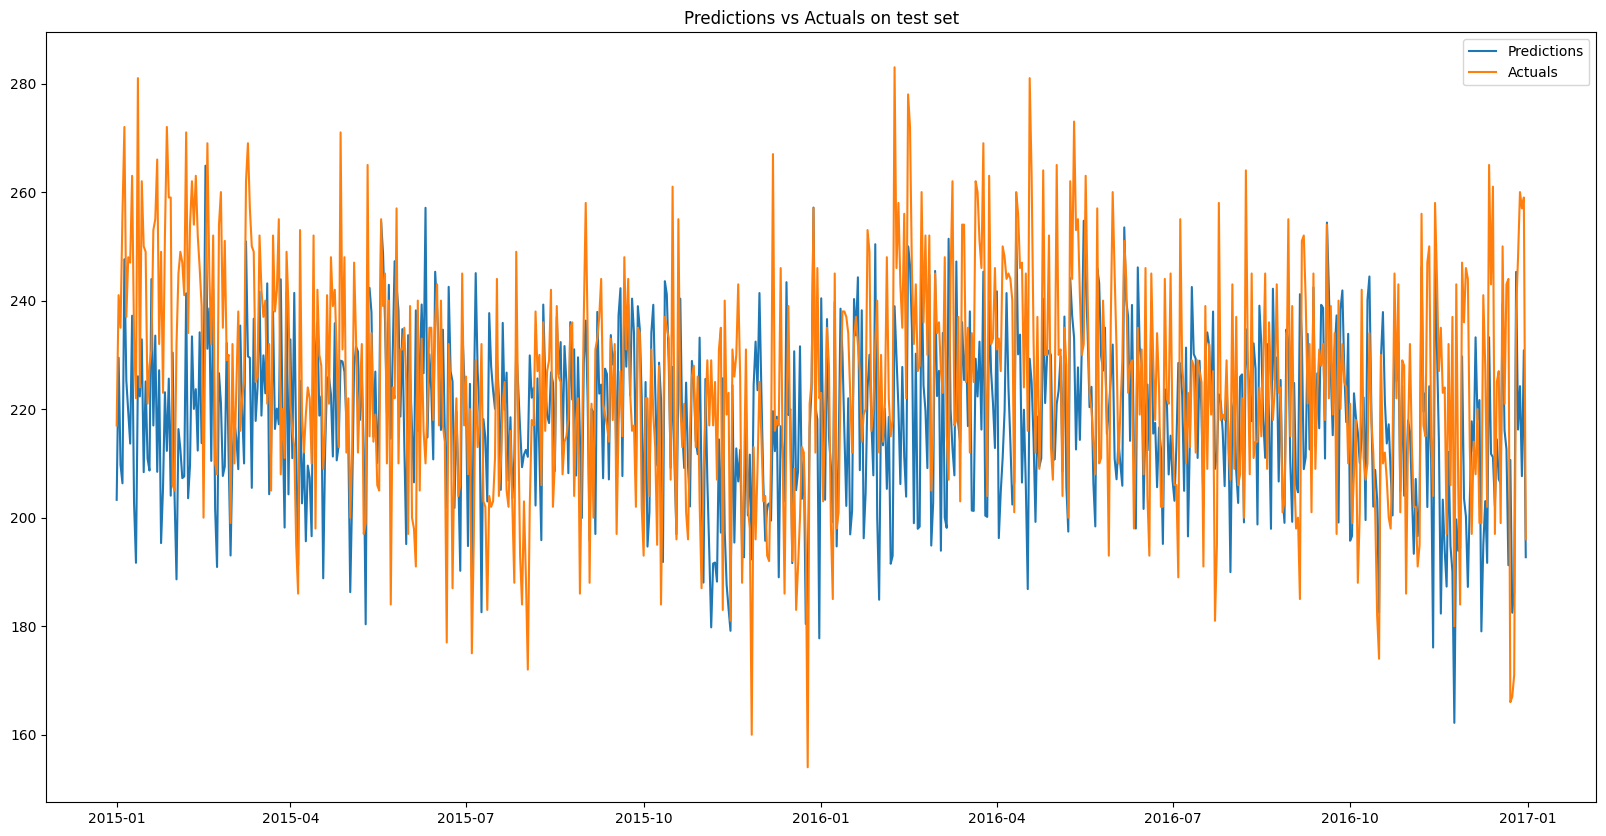

In [43]:
plt.figure(figsize=(20,10))
#graph preds and actuals
plt.plot(y_test.index, preds_test, label='Predictions')
plt.plot(y_test.index, y_test, label='Actuals')
plt.legend()
plt.title('Predictions vs Actuals on test set')
plt.show()


This graph is hard to look at... let's smooth it out a bit and add confidence intervals

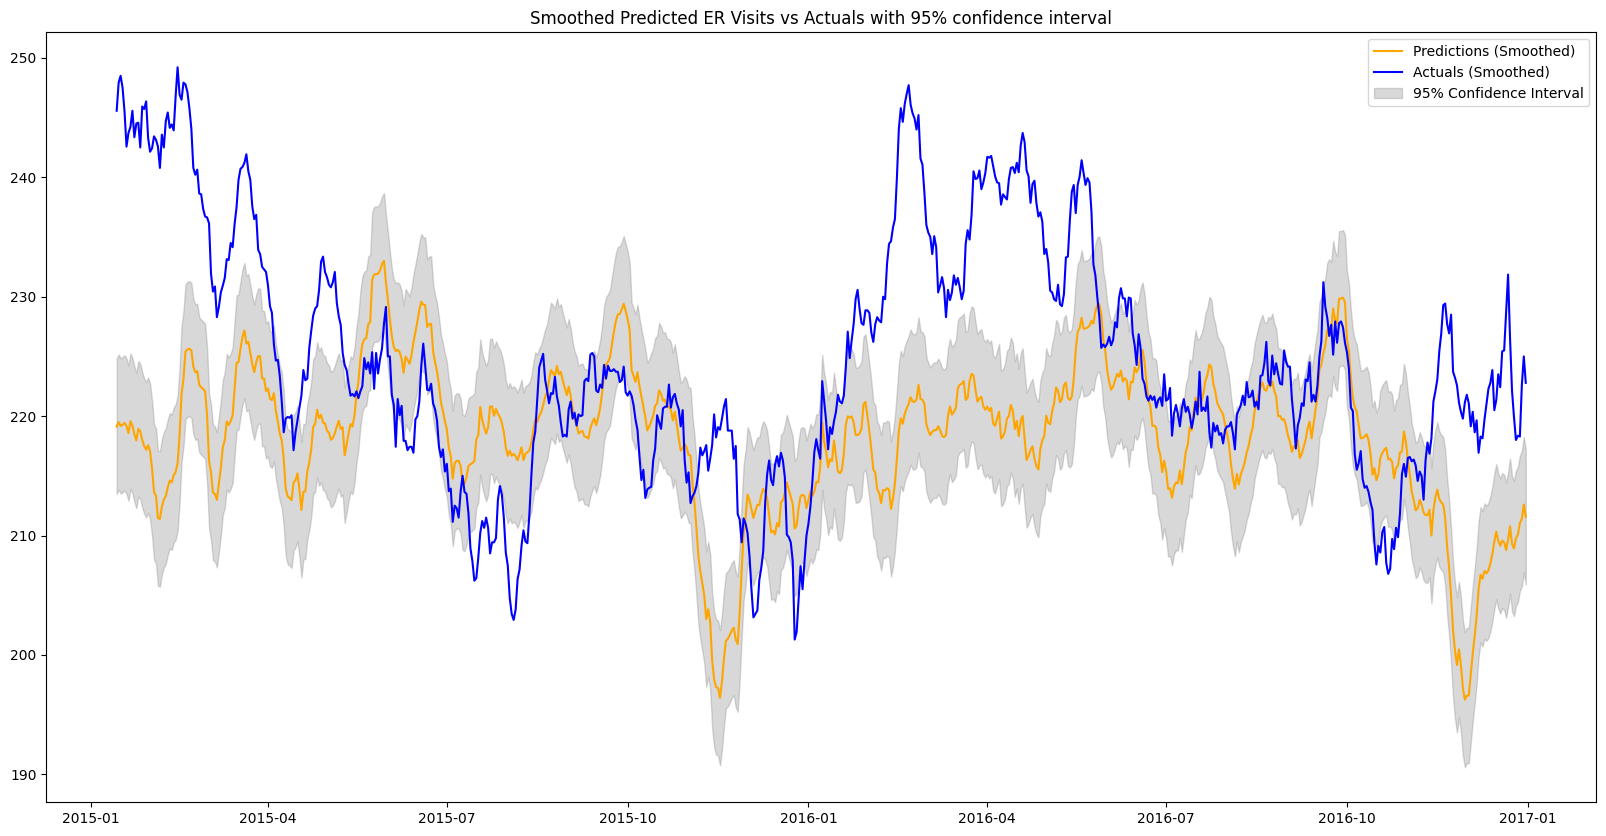

In [54]:
# Calculate rolling averages
window_size = 14  # 7-day rolling window
y_test_smoothed = y_test.rolling(window=window_size).mean()
preds_test_smoothed = pd.Series(preds_test, index=y_test.index).rolling(window=window_size).mean()

# Calculate residuals on training data
residuals = y_train['attendences'] - model.predict(xgb.DMatrix(X_train))

# Calculate the standard deviation of these residualsa
error_std = np.std(residuals)

# Generate upper and lower confidence bounds
confidence_interval = 1.96 * error_std  # 95% confidence interval
upper_bound = preds_test + confidence_interval
lower_bound = preds_test - confidence_interval
#smooth upper and lower bounds
upper_bound_smoothed = pd.Series(upper_bound, index=y_test.index).rolling(window=window_size).mean()
lower_bound_smoothed = pd.Series(lower_bound, index=y_test.index).rolling(window=window_size).mean()

plt.figure(figsize=(20,10))
plt.plot(y_test_smoothed.index, preds_test_smoothed, label='Predictions (Smoothed)', color='orange')
plt.plot(y_test_smoothed.index, y_test_smoothed, label='Actuals (Smoothed)', color='blue')
plt.fill_between(y_test.index, lower_bound_smoothed, upper_bound_smoothed, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.title('Smoothed Predicted ER Visits vs Actuals with 95% confidence interval')
plt.show()


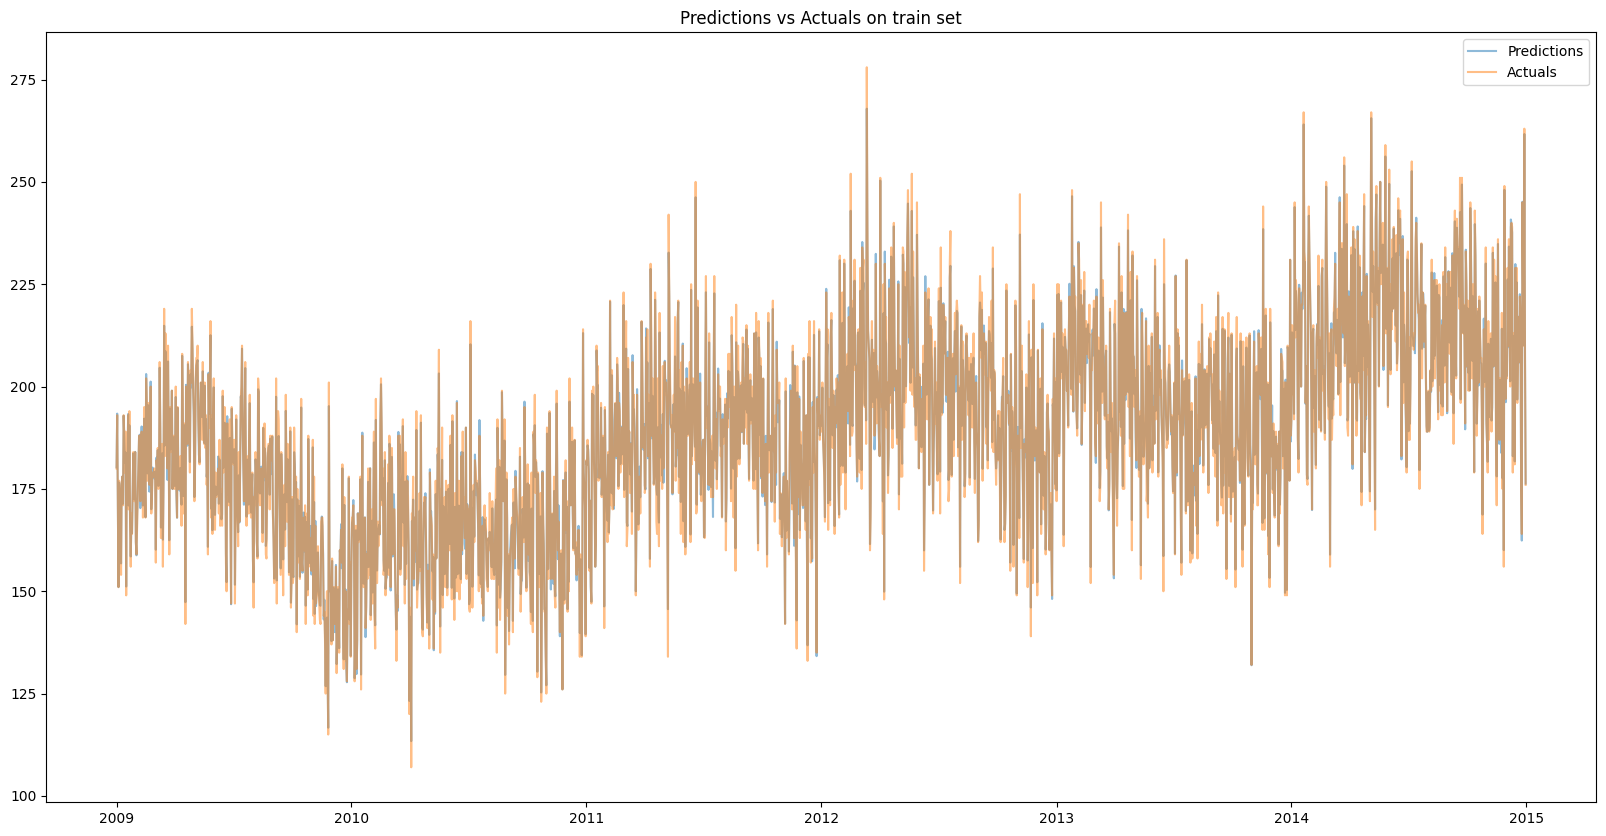

In [41]:
#graph preds and actuals on train data
plt.figure(figsize=(20,10))
plt.plot(y_train.index, preds_train, label='Predictions', alpha=0.5)
plt.plot(y_train.index, y_train, label='Actuals', alpha=0.5)
plt.legend()
plt.title('Predictions vs Actuals on train set')
plt.show()

As expected, the predicted values for the training data line up amazingly well.

# Attempt #2: adding lags and rolling averages

In [79]:
df = pd.read_csv('Davis.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
#drop the columns that are not needed, unnamed:0 and hospital
df = df.drop(['Unnamed: 0', 'hospital'], axis=1)

Autocorrelation graphing to determine which lags are most relevant:

<Figure size 1200x600 with 0 Axes>

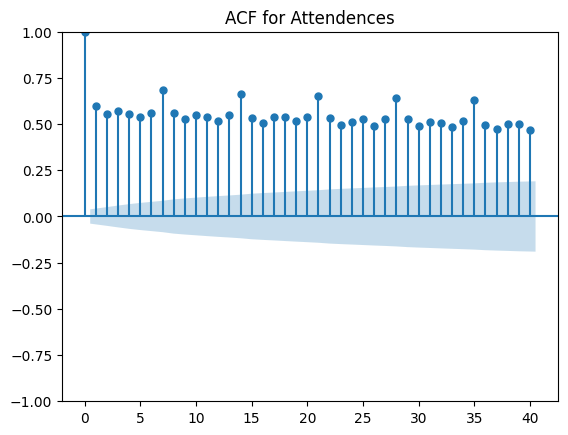

In [77]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 6))
plot_acf(df['attendences'].dropna(), lags=40)  # Adjust lags as necessary
plt.title('ACF for Attendences')
plt.show()

It looks like there is pretty heavy autocorrelation accross all 40, so I'll pick a few short term ones and weekly values to try to capture these trends without overcomplicating the model or leading to overfitting:

In [102]:
df = pd.read_csv('Davis.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
#drop the columns that are not needed, unnamed:0 and hospital
df = df.drop(['Unnamed: 0', 'hospital'], axis=1)

#Creating lag features
df['lag_1'] = df['attendences'].shift(1)
df['lag_2'] = df['attendences'].shift(2)
df['lag_3'] = df['attendences'].shift(3)
df['lag_7'] = df['attendences'].shift(7)
df['lag_14'] = df['attendences'].shift(14)
df['lag_28'] = df['attendences'].shift(28)
df['lag_365'] = df['attendences'].shift(365)

#Adding somewhat arbitrary rolling averages
df['roll_avg_3'] = df['attendences'].rolling(window=3).mean()
#df['roll_avg_7'] = df['attendences'].rolling(window=7).mean()
#df['roll_avg_14'] = df['attendences'].rolling(window=14).mean()
#df['roll_avg_30'] = df['attendences'].rolling(window=30).mean()

#drop rows with any missing values in the lag or rolling avg columns
df = df.dropna()


In [105]:
df.head(5)

,year,monthday,month,day,attendences,min,max,aver,Hosp_ID,Time_ID,...,Year_7,Year_8,lag_1,lag_2,lag_3,lag_7,lag_14,lag_28,lag_365,roll_avg_3
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,2010,101,1,1,156.0,7.0,13.0,11.0,6,366,...,0,0,134.0,157.0,142.0,128.0,181.0,150.0,180.0,149.000000
2010-01-02,2010,102,1,2,168.0,7.0,14.0,11.0,6,367,...,0,0,156.0,134.0,157.0,144.0,145.0,151.0,193.0,152.666667
2010-01-03,2010,103,1,3,168.0,3.0,10.0,7.0,6,368,...,0,0,168.0,156.0,134.0,146.0,131.0,142.0,171.0,164.000000
2010-01-04,2010,104,1,4,171.0,3.0,12.0,7.0,6,369,...,0,0,168.0,168.0,156.0,178.0,173.0,143.0,151.0,169.000000
2010-01-05,2010,105,1,5,165.0,4.0,8.0,6.0,6,370,...,0,0,171.0,168.0,168.0,142.0,133.0,156.0,177.0,168.000000


In [103]:
#separate out the features and target variable
X, y = df.drop('attendences', axis=1), df[['attendences']]
#Split data into train/test split
X_train, X_test, y_train, y_test = X[:'2014'], X['2015':], y[:'2014'], y['2015':]
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)
#train model
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]
n = 10000
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=50,
   # Activate early stopping
   early_stopping_rounds=5
)

[0]	train-rmse:19.17805	validation-rmse:31.01858
[34]	train-rmse:1.37975	validation-rmse:11.39988


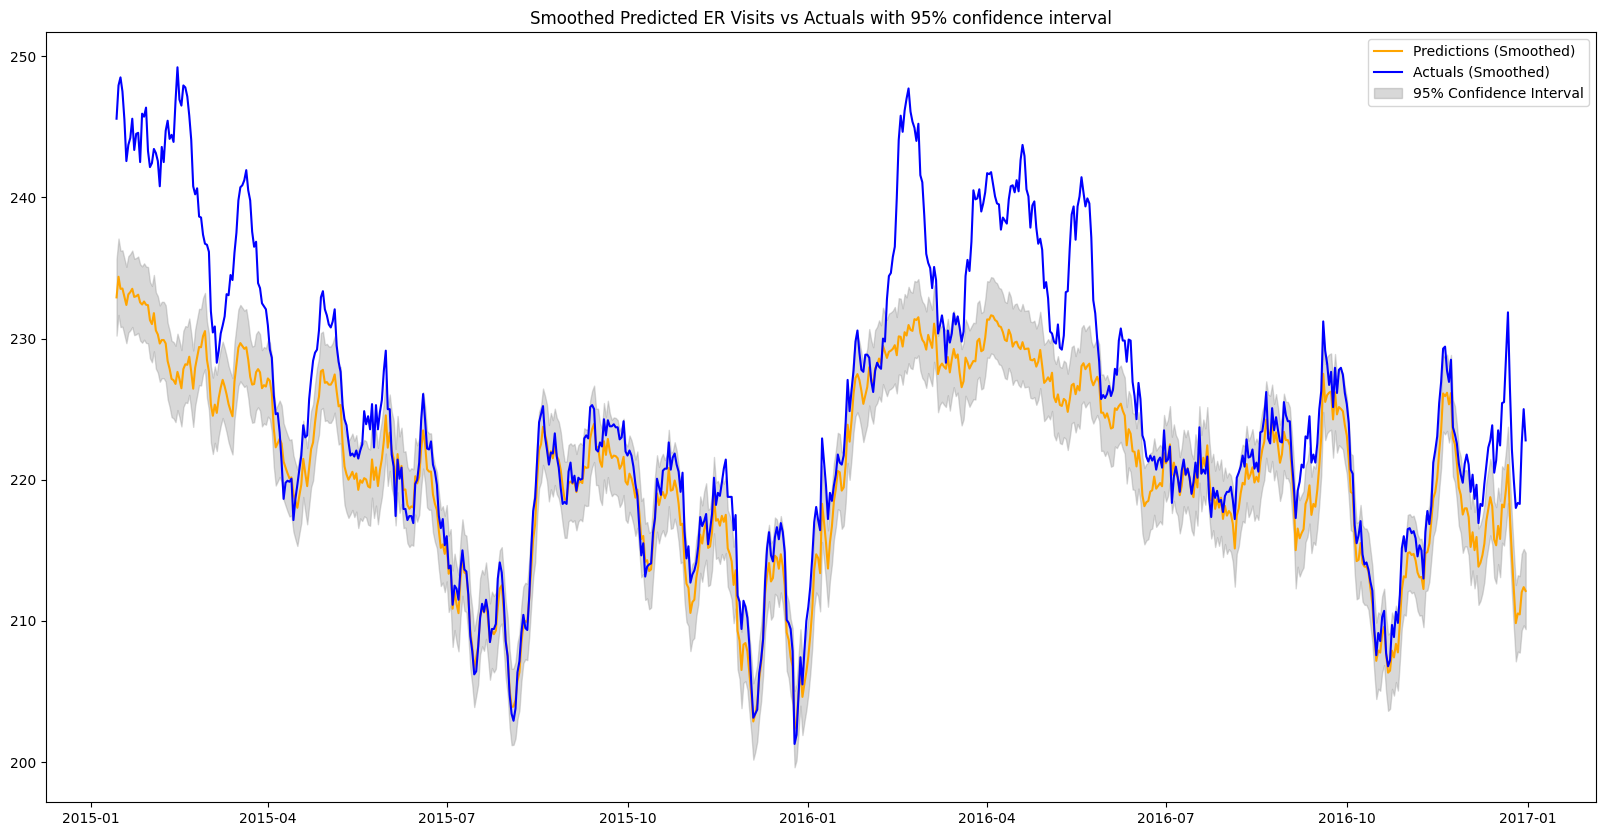

In [104]:
#apply model to the test data
dtest_reg = xgb.DMatrix(X_test)
preds_test = model.predict(dtest_reg)

# Calculate rolling averages
window_size = 14  # 7-day rolling window
y_test_smoothed = y_test.rolling(window=window_size).mean()
preds_test_smoothed = pd.Series(preds_test, index=y_test.index).rolling(window=window_size).mean()

# Calculate residuals on training data
residuals = y_train['attendences'] - model.predict(xgb.DMatrix(X_train))

# Calculate the standard deviation of these residualsa
error_std = np.std(residuals)

# Generate upper and lower confidence bounds
confidence_interval = 1.96 * error_std  # 95% confidence interval
upper_bound = preds_test + confidence_interval
lower_bound = preds_test - confidence_interval
#smooth upper and lower bounds
upper_bound_smoothed = pd.Series(upper_bound, index=y_test.index).rolling(window=window_size).mean()
lower_bound_smoothed = pd.Series(lower_bound, index=y_test.index).rolling(window=window_size).mean()

plt.figure(figsize=(20,10))
plt.plot(y_test_smoothed.index, preds_test_smoothed, label='Predictions (Smoothed)', color='orange')
plt.plot(y_test_smoothed.index, y_test_smoothed, label='Actuals (Smoothed)', color='blue')
plt.fill_between(y_test.index, lower_bound_smoothed, upper_bound_smoothed, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.title('Smoothed Predicted ER Visits vs Actuals with 95% confidence interval')
plt.show()


# Attempt #3: Using above augmented data with grid search hyperparameter optimization

In [106]:
df = pd.read_csv('Davis.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
#drop the columns that are not needed, unnamed:0 and hospital
df = df.drop(['Unnamed: 0', 'hospital'], axis=1)

#Creating lag features
df['lag_1'] = df['attendences'].shift(1)
df['lag_2'] = df['attendences'].shift(2)
df['lag_3'] = df['attendences'].shift(3)
df['lag_7'] = df['attendences'].shift(7)
df['lag_14'] = df['attendences'].shift(14)
df['lag_28'] = df['attendences'].shift(28)
df['lag_365'] = df['attendences'].shift(365)

#Adding somewhat arbitrary rolling averages
df['roll_avg_3'] = df['attendences'].rolling(window=3).mean()
#df['roll_avg_7'] = df['attendences'].rolling(window=7).mean()
#df['roll_avg_14'] = df['attendences'].rolling(window=14).mean()
#df['roll_avg_30'] = df['attendences'].rolling(window=30).mean()

#drop rows with any missing values in the lag or rolling avg columns
df = df.dropna()

In [107]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

#separate out the features and target variable
X, y = df.drop('attendences', axis=1), df[['attendences']]
#Split data into train/test split
X_train, X_test, y_train, y_test = X[:'2014'], X['2015':], y[:'2014'], y['2015':]
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Define the model
model = XGBRegressor()

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.7, 0.8, 0.9]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}


In [114]:
#train model
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]
n = 10000
model = xgb.train(
   params=grid_search.best_params_,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=50,
   # Activate early stopping
   early_stopping_rounds=25
)

[0]	train-rmse:23.26391	validation-rmse:36.72013
[50]	train-rmse:6.04741	validation-rmse:12.85865
[100]	train-rmse:3.43751	validation-rmse:11.24115


c:\Users\kentm\Documents\Jupyter Notebooks\ed visit timeseries\.conda\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:11:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[150]	train-rmse:2.20958	validation-rmse:10.81809
[200]	train-rmse:1.60785	validation-rmse:10.53766
[250]	train-rmse:1.28960	validation-rmse:10.37736
[300]	train-rmse:1.07537	validation-rmse:10.32707
[349]	train-rmse:0.92537	validation-rmse:10.30443


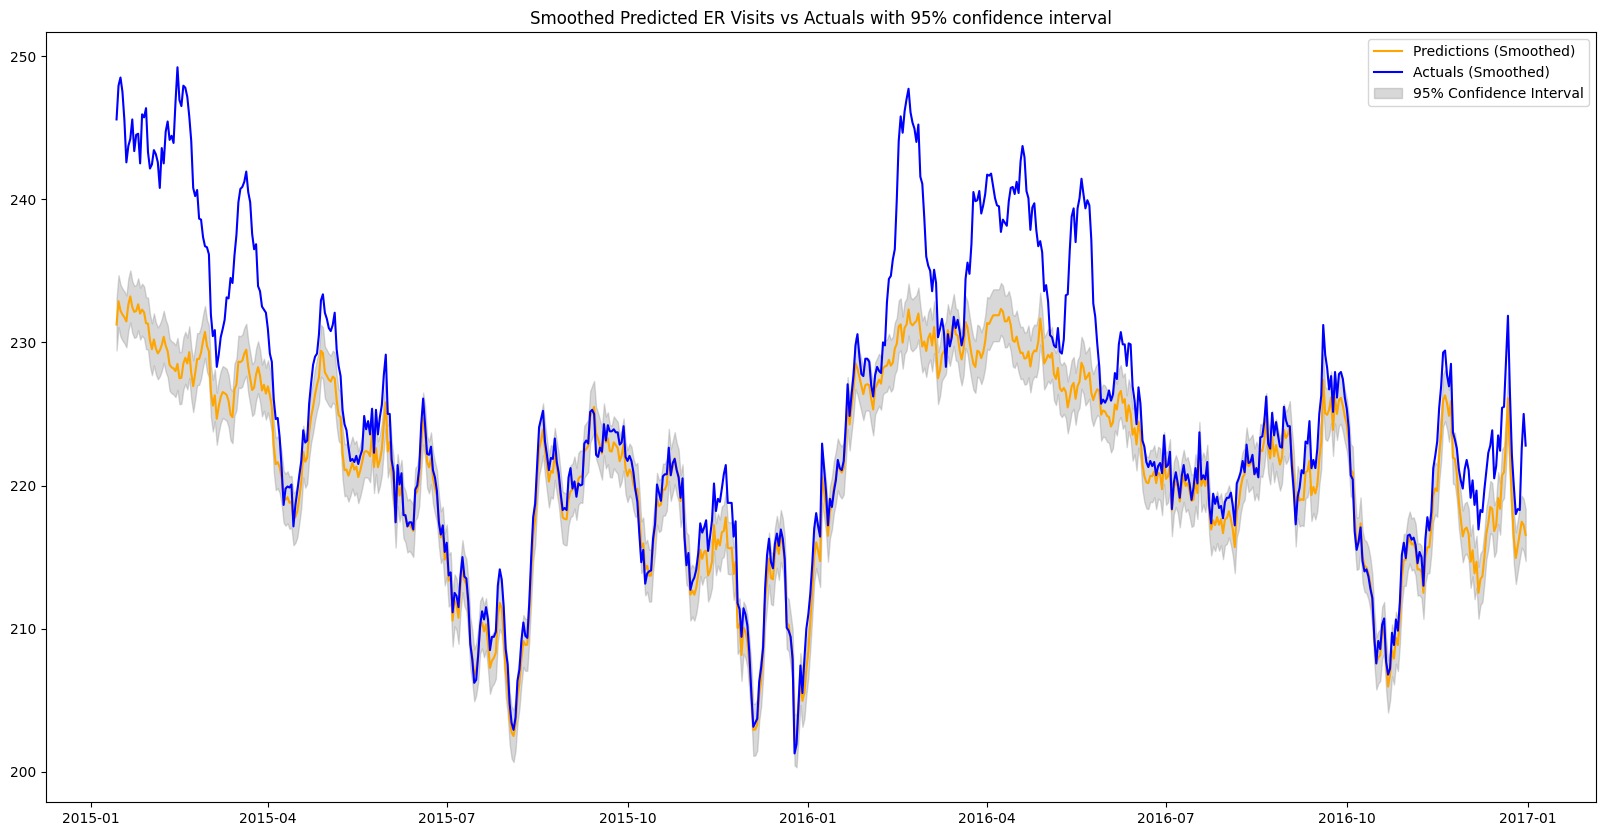

In [115]:
#apply model to the test data
dtest_reg = xgb.DMatrix(X_test)
preds_test = model.predict(dtest_reg)

# Calculate rolling averages
window_size = 14  # 7-day rolling window
y_test_smoothed = y_test.rolling(window=window_size).mean()
preds_test_smoothed = pd.Series(preds_test, index=y_test.index).rolling(window=window_size).mean()

# Calculate residuals on training data
residuals = y_train['attendences'] - model.predict(xgb.DMatrix(X_train))

# Calculate the standard deviation of these residualsa
error_std = np.std(residuals)

# Generate upper and lower confidence bounds
confidence_interval = 1.96 * error_std  # 95% confidence interval
upper_bound = preds_test + confidence_interval
lower_bound = preds_test - confidence_interval
#smooth upper and lower bounds
upper_bound_smoothed = pd.Series(upper_bound, index=y_test.index).rolling(window=window_size).mean()
lower_bound_smoothed = pd.Series(lower_bound, index=y_test.index).rolling(window=window_size).mean()

plt.figure(figsize=(20,10))
plt.plot(y_test_smoothed.index, preds_test_smoothed, label='Predictions (Smoothed)', color='orange')
plt.plot(y_test_smoothed.index, y_test_smoothed, label='Actuals (Smoothed)', color='blue')
plt.fill_between(y_test.index, lower_bound_smoothed, upper_bound_smoothed, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.title('Smoothed Predicted ER Visits vs Actuals with 95% confidence interval')
plt.show()

# Attempt #4: Cross validating performance accross multiple time series splits

In [129]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Load and prepare the data
df = pd.read_csv('Davis.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
df = df.drop(['Unnamed: 0', 'hospital'], axis=1)

# Add lag and rolling features to the whole dataset
lags = [1, 2, 3, 7, 14, 28, 365]
for lag in lags:
    df[f'lag_{lag}'] = df['attendences'].shift(lag)

rolling_windows = [3]
for window in rolling_windows:
    df[f'rolling_avg_{window}'] = df['attendences'].rolling(window=window).mean()

# Drop rows with NaN values that were created by shift and rolling
df.dropna(inplace=True)

# Time Series Cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]
    X_train, y_train = train.drop('attendences', axis=1), train['attendences']
    X_test, y_test = test.drop('attendences', axis=1), test['attendences']

    # Define the model
    model = XGBRegressor()

    # Parameter grid
    param_grid = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200],
        'subsample': [0.7, 0.8, 0.9]
    }

    # Grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)

    # Use best parameters to train the model
    best_params = grid_search.best_params_
    final_model = XGBRegressor(**best_params)
    final_model.fit(X_train, y_train)

    # Predict and evaluate
    predictions = final_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"Fold RMSE: {rmse:.3f}")


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Fold RMSE: 11.868
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Fold RMSE: 6.593
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Fold RMSE: 6.141
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Fold RMSE: 10.375
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Fold RMSE: 5.128


## Training final model

In [132]:
# Assuming best_params are defined from your previous GridSearch
df = pd.read_csv('Davis.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
#drop the columns that are not needed, unnamed:0 and hospital
df = df.drop(['Unnamed: 0', 'hospital'], axis=1)

#Creating lag features
df['lag_1'] = df['attendences'].shift(1)
df['lag_2'] = df['attendences'].shift(2)
df['lag_3'] = df['attendences'].shift(3)
df['lag_7'] = df['attendences'].shift(7)
df['lag_14'] = df['attendences'].shift(14)
df['lag_28'] = df['attendences'].shift(28)
df['lag_365'] = df['attendences'].shift(365)

#Adding somewhat arbitrary rolling averages
df['roll_avg_3'] = df['attendences'].rolling(window=3).mean()
#df['roll_avg_7'] = df['attendences'].rolling(window=7).mean()
#df['roll_avg_14'] = df['attendences'].rolling(window=14).mean()
#df['roll_avg_30'] = df['attendences'].rolling(window=30).mean()

#drop rows with any missing values in the lag or rolling avg columns
df = df.dropna()

#separate out the features and target variable
X, y = df.drop('attendences', axis=1), df[['attendences']]
#Split data into train/test split
X_train, X_test, y_train, y_test = X[:'2014'], X['2015':], y[:'2014'], y['2015':]
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

best_params = {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

predictions = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Fold RMSE: {rmse:.3f}")

Fold RMSE: 10.965


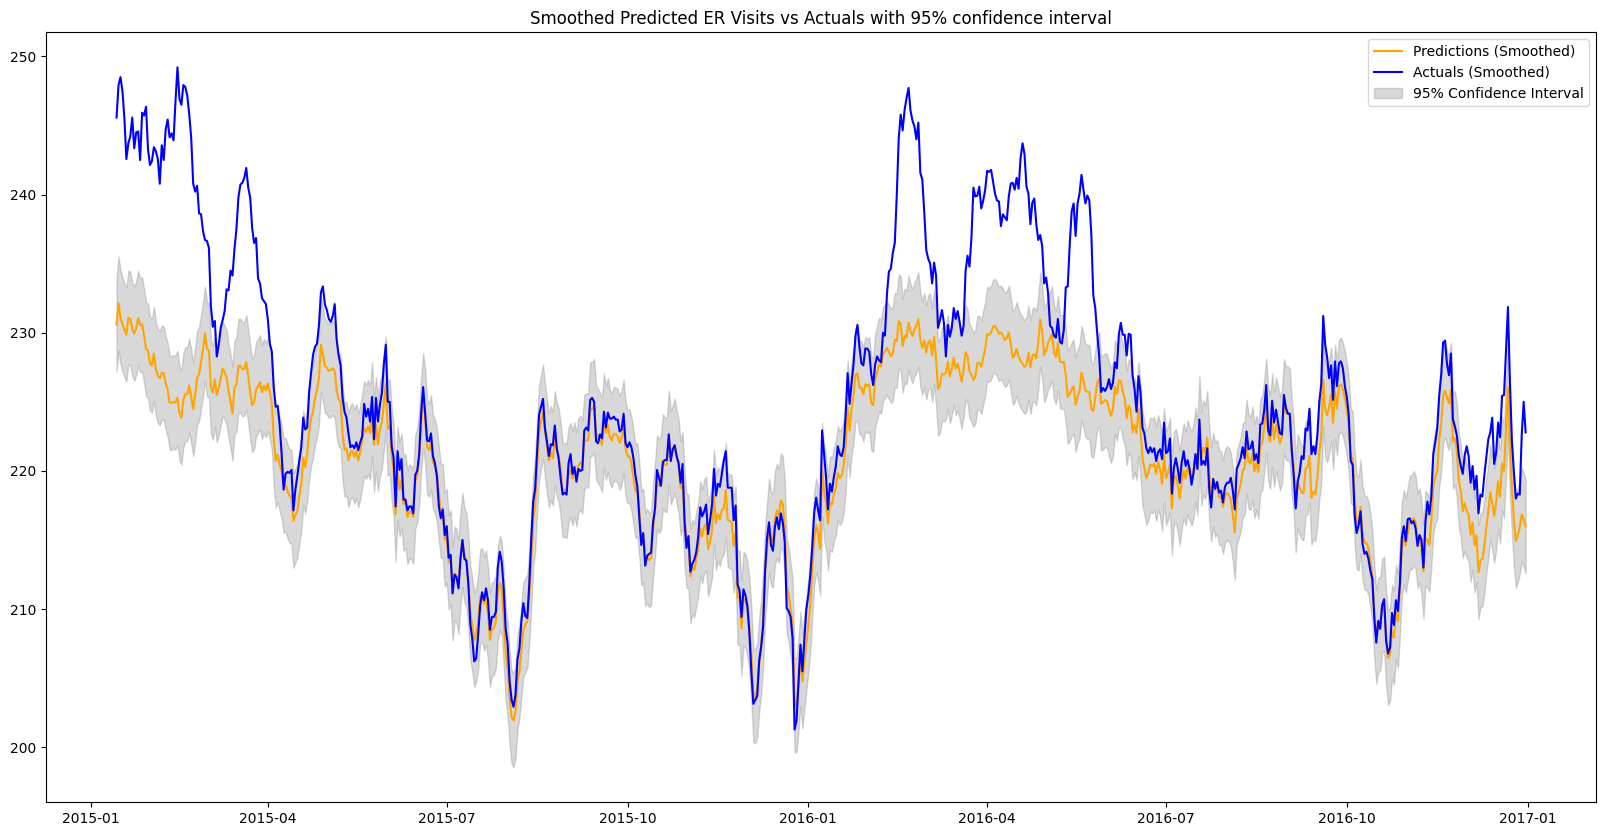

In [137]:
#apply model to the test data
dtest_reg = xgb.DMatrix(X_test)
preds_test = final_model.predict(X_test)

# Calculate rolling averages
window_size = 14  # 7-day rolling window
y_test_smoothed = y_test.rolling(window=window_size).mean()
preds_test_smoothed = pd.Series(preds_test, index=y_test.index).rolling(window=window_size).mean()

# Calculate residuals on training data
residuals = y_train['attendences'] - final_model.predict(X_train)

# Calculate the standard deviation of these residualsa
error_std = np.std(residuals)

# Generate upper and lower confidence bounds
confidence_interval = 1.96 * error_std  # 95% confidence interval
upper_bound = preds_test + confidence_interval
lower_bound = preds_test - confidence_interval
#smooth upper and lower bounds
upper_bound_smoothed = pd.Series(upper_bound, index=y_test.index).rolling(window=window_size).mean()
lower_bound_smoothed = pd.Series(lower_bound, index=y_test.index).rolling(window=window_size).mean()

plt.figure(figsize=(20,10))
plt.plot(y_test_smoothed.index, preds_test_smoothed, label='Predictions (Smoothed)', color='orange')
plt.plot(y_test_smoothed.index, y_test_smoothed, label='Actuals (Smoothed)', color='blue')
plt.fill_between(y_test.index, lower_bound_smoothed, upper_bound_smoothed, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.title('Smoothed Predicted ER Visits vs Actuals with 95% confidence interval')
plt.show()